In [43]:
from state_reconstruction_functions import *
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from tqdm import tqdm
import math
import cmath
from scipy.integrate import simpson, romb
from scipy.stats import iqr, norm, gaussian_kde
from scipy.special import erfc, wofz
from scipy.interpolate import RegularGridInterpolator
import pickle
import os
import warnings

In [55]:
mu_max = 6
alpha = 1 + 0.5j

n = 415
N_mu = (int(np.round(mu_max * np.log(n))))
n_precision = 1000

resolution = 50
g_list = np.linspace(-8, 8, resolution)
h_list = np.linspace(-8, 8, resolution)
g, h = np.meshgrid(g_list, h_list)


kappa = 1
correction = False
trial_times = 10


rho_estimate = rho_max(mu_max, N_mu, kappa, n_precision, alpha, g_list, h_list, n, trial_times = trial_times, correction = correction)


100%|██████████| 50/50 [00:08<00:00,  6.23it/s]


In [56]:
trial_index = 0 # The index of the trial to visualize
rho_estimate_sub = rho_estimate[trial_index]


g_grid, h_grid = np.meshgrid(g_list, h_list)

y = np.linspace(-4, 4, resolution)
yp = np.linspace(-4, 4, resolution)
Y, Yp = np.meshgrid(y, yp)

G = Y - Yp
H = Y + Yp

H_clipped = np.clip(H, h_list[0], h_list[-1])
G_clipped = np.clip(G, g_list[0], g_list[-1])

points = np.stack([H_clipped.ravel(), G_clipped.ravel()], axis=-1)

real_interp = RegularGridInterpolator((h_list, g_list), rho_estimate_sub.real)
imag_interp = RegularGridInterpolator((h_list, g_list), rho_estimate_sub.imag)

real_vals = real_interp(points).reshape(Y.shape)
imag_vals = imag_interp(points).reshape(Y.shape)
full_vals = real_vals + 1j * imag_vals

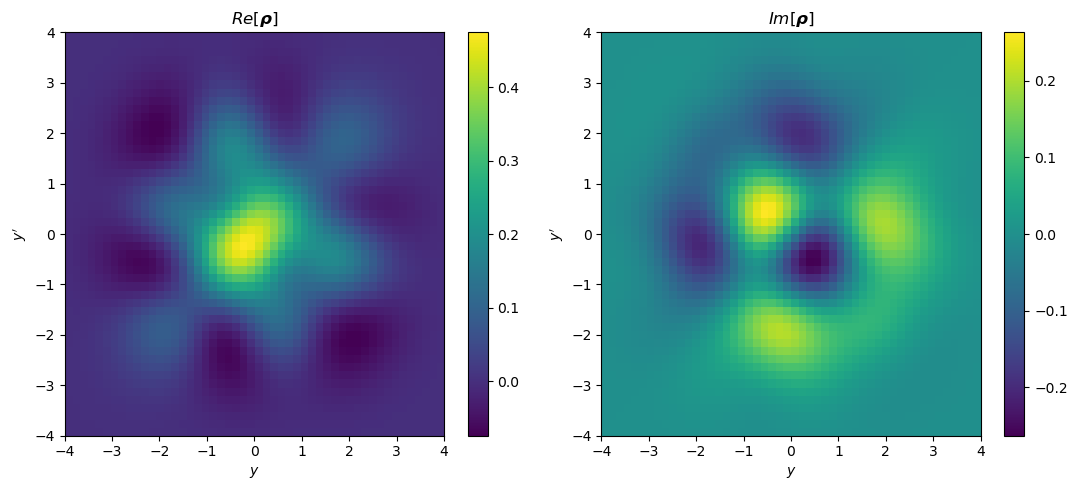

In [57]:
Y, Y_prime = np.meshgrid(y, yp)
rho_list = true_rho(alpha, Y, Y_prime)


plt.figure(figsize=(11,5))


plt.subplot(1, 2, 1)
plt.imshow(rho_list.real, extent=[y[0], y[-1], yp[0], yp[-1]],
        origin='lower', aspect='auto', cmap='viridis')
plt.xlabel(r'$y$')
plt.ylabel(r"$y^\prime$")
plt.colorbar()
plt.title(r"$Re[\boldsymbol{\rho}]$")

plt.subplot(1, 2, 2)
plt.imshow(rho_list.imag, extent=[y[0], y[-1], yp[0], yp[-1]],
        origin='lower', aspect='auto', cmap='viridis')
plt.xlabel(r'$y$')
plt.ylabel(r"$y^\prime$")
plt.colorbar()
plt.title(r"$Im[\boldsymbol{\rho}]$")
plt.tight_layout()

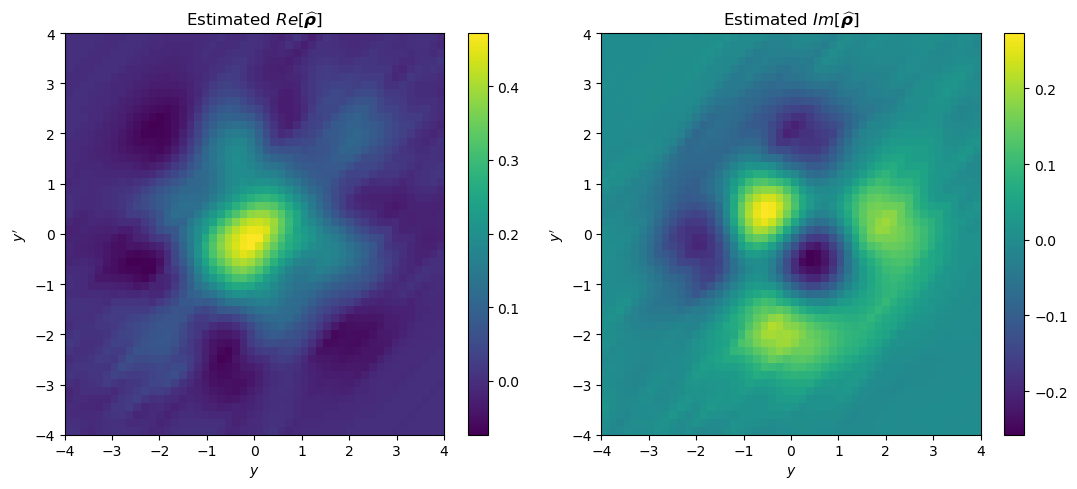

In [58]:
plt.figure(figsize=(11,5))


plt.subplot(1, 2, 1)
plt.imshow(full_vals.real, extent=[y[0], y[-1], yp[0], yp[-1]],
        origin='lower', aspect='auto', cmap='viridis')
plt.xlabel(r'$y$')
plt.ylabel(r"$y^\prime$")
plt.colorbar()
plt.title(r"Estimated $Re[\widehat\boldsymbol{\rho}]$")

plt.subplot(1, 2, 2)
plt.imshow(full_vals.imag, extent=[y[0], y[-1], yp[0], yp[-1]],
        origin='lower', aspect='auto', cmap='viridis')
plt.xlabel(r'$y$')
plt.ylabel(r"$y^\prime$")
plt.colorbar()
plt.title(r"Estimated $Im[\widehat\boldsymbol{\rho}]$")
plt.tight_layout()

In [59]:
# Find out L_{\infty}

g_grid, h_grid = np.meshgrid(g_list, h_list)

y = np.linspace(-4, 4, resolution)
yp = np.linspace(-4, 4, resolution)
Y, Yp = np.meshgrid(y, yp)

G = Y - Yp
H = Y + Yp

H_clipped = np.clip(H, h_list[0], h_list[-1])
G_clipped = np.clip(G, g_list[0], g_list[-1])

points = np.stack([H_clipped.ravel(), G_clipped.ravel()], axis=-1)


error_map = np.zeros_like(rho_list, dtype=float)

for trial_index in range(trial_times):
    rho_estimate_sub = rho_estimate[trial_index]

    real_interp = RegularGridInterpolator((h_list, g_list), rho_estimate_sub.real)
    imag_interp = RegularGridInterpolator((h_list, g_list), rho_estimate_sub.imag)

    real_vals = real_interp(points).reshape(Y.shape)
    imag_vals = imag_interp(points).reshape(Y.shape)
    full_vals = real_vals + 1j * imag_vals

    error_map += 1 / trial_times * np.abs(full_vals - rho_list)**2

L_infty_error = np.max(error_map)

print(f"L_infty error: {L_infty_error}")

L_infty error: 0.0006145712364651506
